Exercise-based on a dataset published on Kaggle: https://www.kaggle.com/mohamedzayton/medical-cost-personal

**Goal:** Finding a model which can  accurately predict insurance costs.

**Propouse:**
- Accomplishing an exploratory data analysis on the dataset.
- Identifying and dealing with possible skewed data, where applicable.
- Accomplishing hypothesis tests by analyzing data variation, where applicable.
- Accomplishing normality tests.
- Identifying possible correlations.
- Solving possible overfitting and underfitting problems, if necessary.
- Accomplishing data normalization and coeficient regularization techniques, if necessary.
- Finding which algorithm have the best performance: Linear Regression, Lasso, and RandomForestRegressor
- Applying K-Fold cross-validation.
- Validating results with confusion matrix
- Checking algorithms' results variability.

**Solution author's Linkedin profile:** https://bit.ly/3tsOnU3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os
import math
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm, shapiro
import warnings

warnings.filterwarnings("ignore")
abs_path = os.getcwd()

# 1. Get dataset by Kaggle API

In [2]:
parquet_file = "insurance.parquet"
csv_file = "insurance.csv"
zip_file = "insurance.zip"

if os.path.isfile(parquet_file):
    print ("There is a parquet file!!!")
    dataset = pd.read_parquet(parquet_file)
else:
    """
    Get the compressed dataset (.zip file), 
    Extract .csv file,
    Deletr .zip file,
    Load .csv jupyter to jupyter notebook,
    Delete .csv file,
    Generate .parquet file
    """
    print ("There is no file")
    !kaggle datasets download -d mirichoi0218/insurance
    with zipfile.ZipFile(zip_file,"r") as zip_ref:
        zip_ref.extractall(abs_path)
    os.remove(zip_file)
    dataset = pd.read_csv(csv_file)
    dataset.to_parquet(parquet_file, engine='pyarrow')
    os.remove(csv_file)
    
dataset.head()

There is a parquet file!!!


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 2. Exploratory Data Analysis

In [3]:
dataset.shape

(1338, 7)

**Analysis:** By getting "non-null" results below, it proves:
- There is no null data, so there is no need to delete elements/columns or to add data by interpolation.

**Analysis:** Between explicative variables, there are some qualitative variables ("object" type), quantiative ones - discrete (most of them of "int64" type) and continuous (most of them of "float64"). 

**Analysis:** Afterwards, it was noticed it is necessary to apply data normalization technique to some columns.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
dataset.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
np.unique(dataset['region'], return_counts=True)

(array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object),
 array([324, 325, 364, 325], dtype=int64))

**Analysis:** There is some skewed data, it can be seen on "charge" column histogram and on its boxplot.

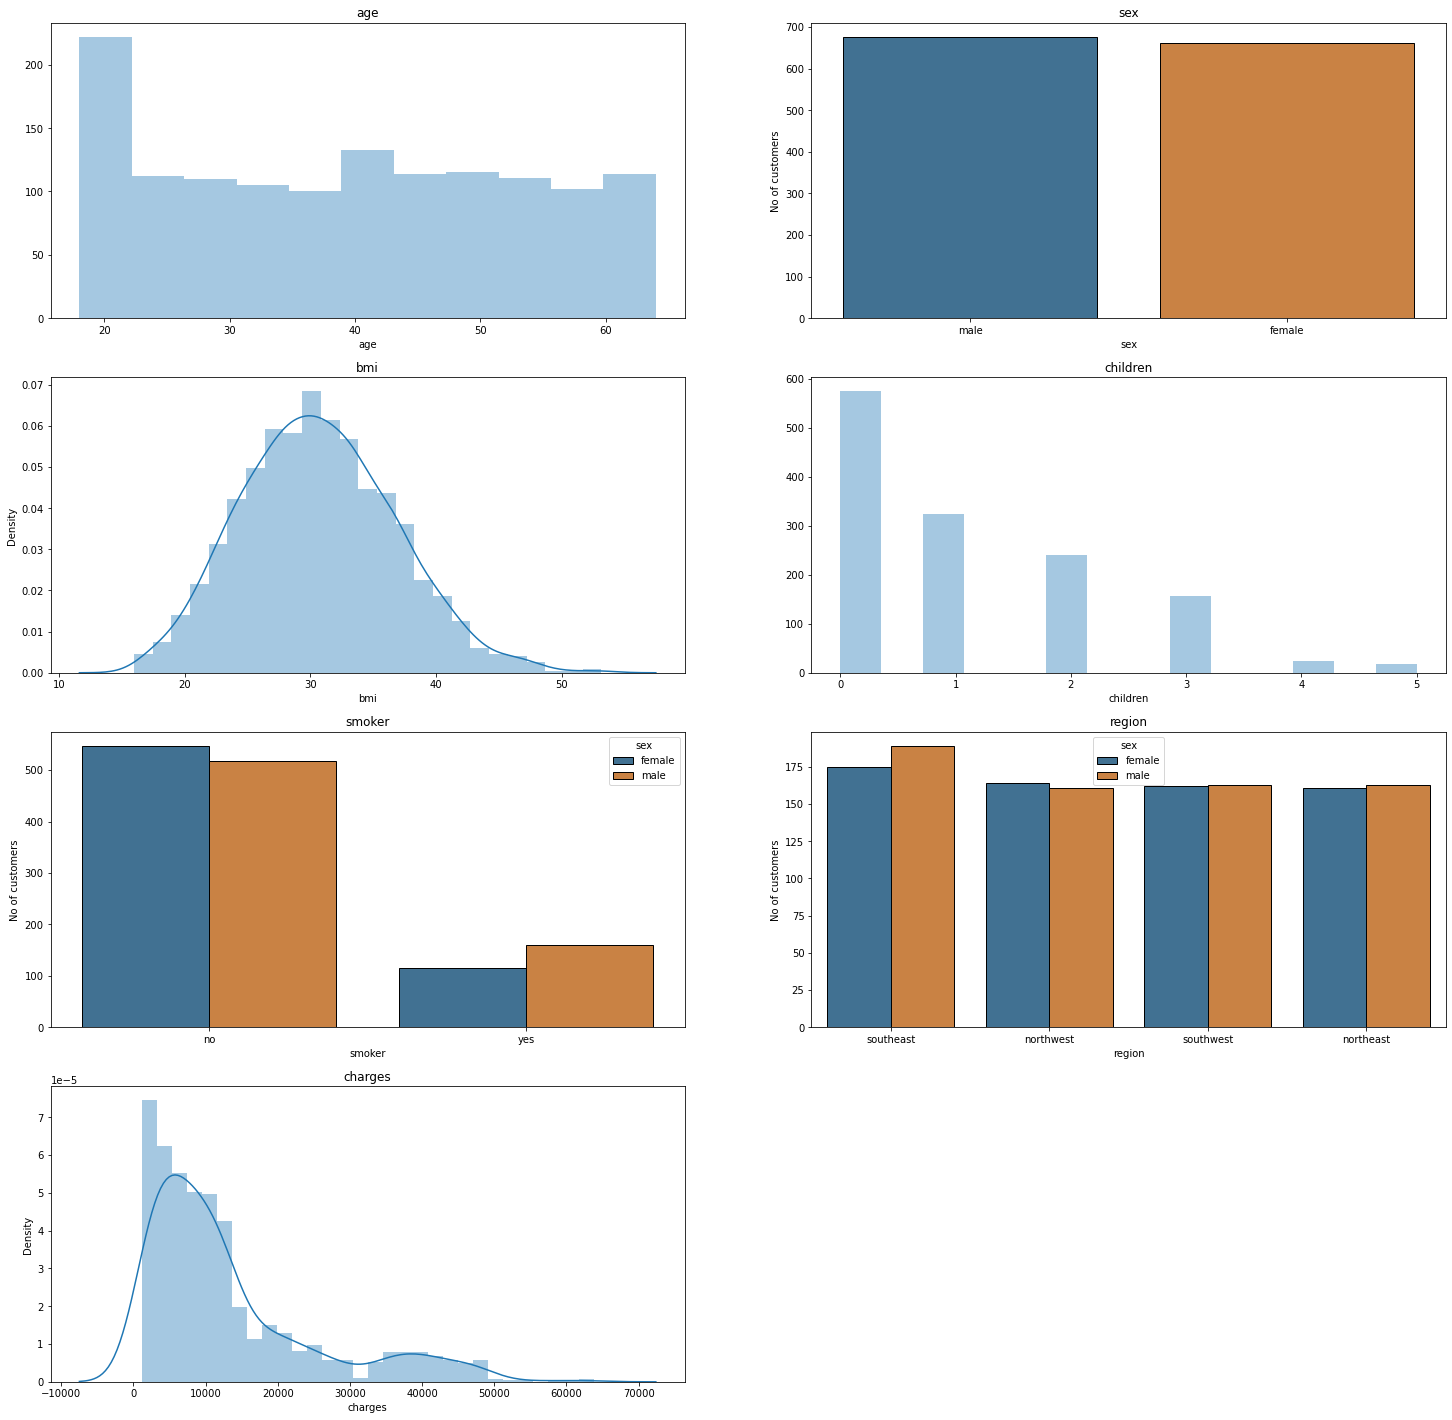

In [7]:
subplot_columns_amount = 2
first_index = 0
subplot_rows_amount = math.ceil(len(dataset.iloc[:,first_index:].columns)/subplot_columns_amount)

_, ax = plt.subplots(subplot_rows_amount, subplot_columns_amount, figsize=(25,25))

for count, column in enumerate(dataset.iloc[:,first_index:].columns):
    current_ax = ax[count//subplot_columns_amount][count%subplot_columns_amount]
    current_ax.set_title(column)
    if dataset[column].dtype in ["int64", "float64"]:
        kde = True if dataset[column].dtype == "float64" else False
        sns.distplot(dataset[column], kde=kde, ax=current_ax)
    else:
        data = pd.DataFrame(dataset[column].groupby(dataset[column]).size().reset_index(name='Amount'))
        current_ax.set_ylabel("No of customers")
        # Descending ordering based on element amount for each class of each column
        # Afterwards, reshaping operation is needed after .value, because it returns a matrix
        order = dataset[column].groupby(dataset[column]).size().reset_index(name='grouping').sort_values(by=['grouping'], ascending=False).iloc[:,:1].values
        hue = dataset['sex'] if column != "sex" else None
        sns.countplot(x = dataset[column], edgecolor = 'black', saturation = 0.55, 
                          ax=current_ax, hue=hue, order=order.reshape((order.shape[0])))
        current_ax.set_ylabel('No of customers')
        
# Delete empty frames
qtd_frames_vazios = subplot_columns_amount*subplot_rows_amount - len(dataset.iloc[:,first_index:].columns)
[ax.flat[-i].set_visible(False) for i in range(1, qtd_frames_vazios+1)]
plt.show()
plt.close()

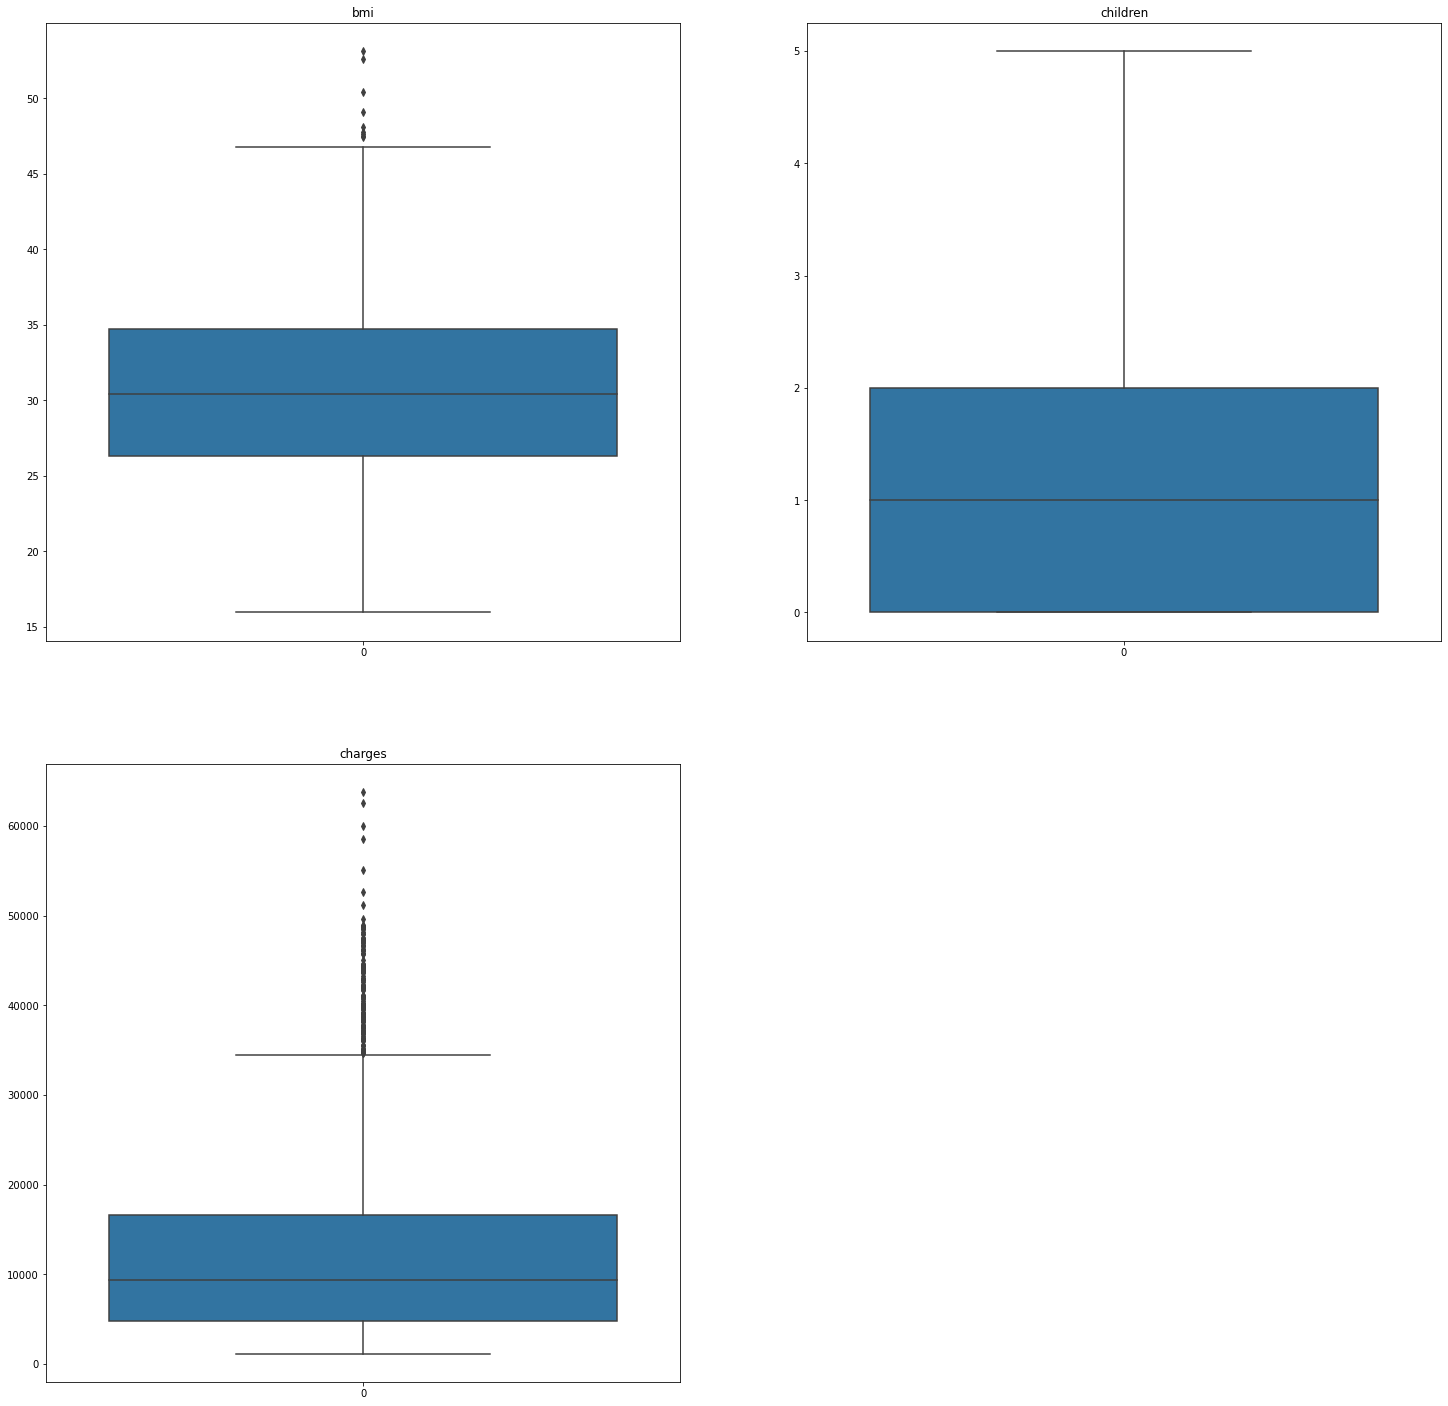

In [8]:
numeric_columns = (dataset.iloc[:,1:].dtypes != "object").reset_index(name='Amount').query('Amount == True')['index'].values

subplot_columns_amount = 2
subplot_rows_amount = math.ceil(len(numeric_columns)/subplot_columns_amount)
_, ax = plt.subplots(subplot_rows_amount, subplot_columns_amount, figsize=(25,25))

for count, column in enumerate(numeric_columns):
    current_ax = ax[count//subplot_columns_amount][count%subplot_columns_amount]
    current_ax.set_title(column)
    plt.subplot(sns.boxplot(data=dataset[column], ax=current_ax))

# Delete empty frames
amount_empty_frames = subplot_columns_amount*subplot_rows_amount - len(numeric_columns)
[ax.flat[-i].set_visible(False) for i in range(1, amount_empty_frames+1)]
plt.show()
plt.close()

In [9]:
# Encode data

dataset_encoded = dataset.iloc[:,:].copy()

for column in dataset_encoded.columns:
    if dataset_encoded[column].dtype == "object":
        label_encoder = LabelEncoder()
        dataset_encoded[column] = label_encoder.fit_transform(dataset_encoded[column])
dataset_encoded.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


**Analysis:** The heatmap for Pearson correlation table below proves no explicative variable is, at least, on moderate level, according to Evans classification, Evans (1996, also http://leg.ufpr.br/~silvia/CE003/node74.html, on Brazilian portuguese)

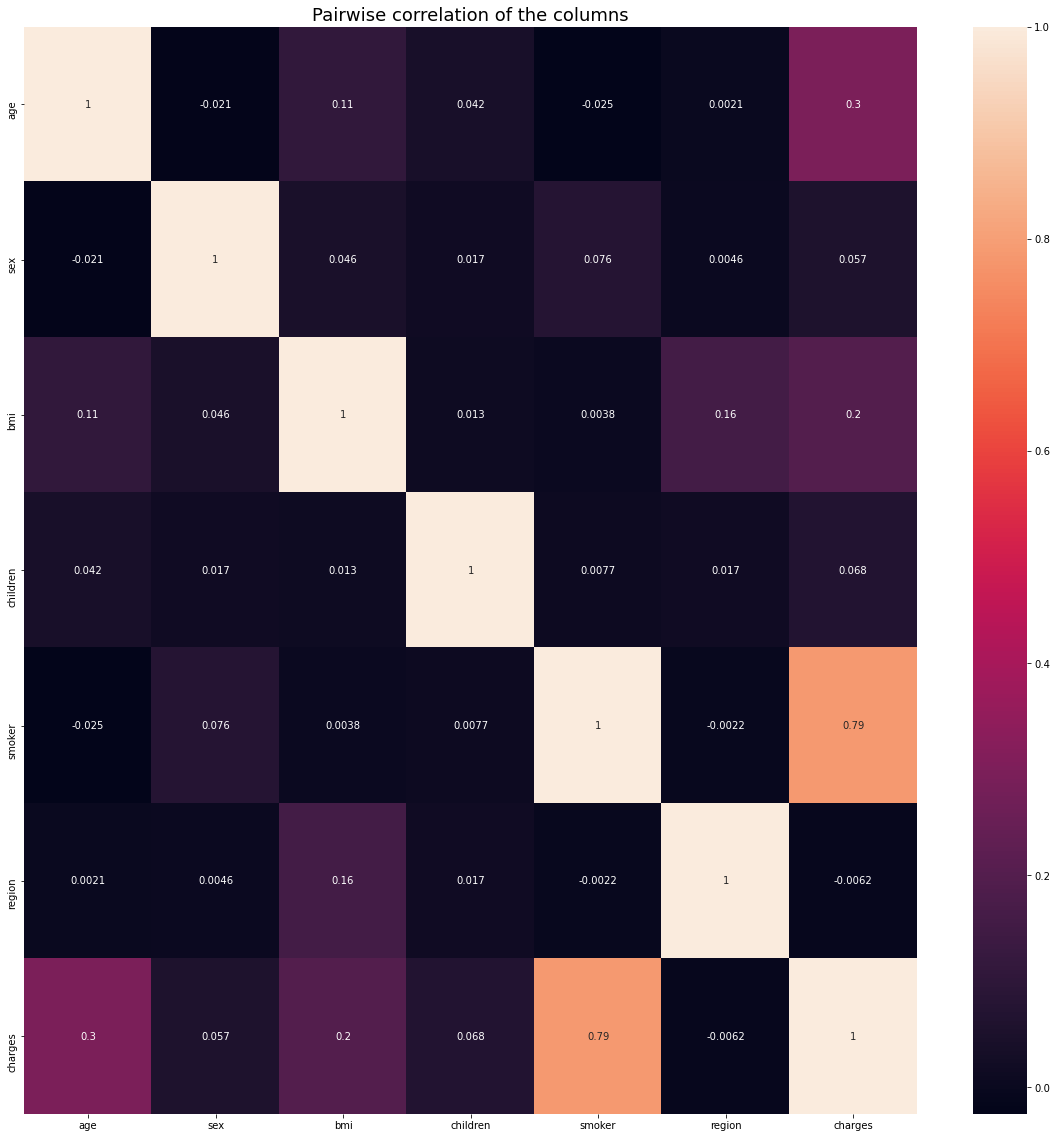

In [10]:
fig, ax = plt.subplots(figsize = (20, 20))
plt.title("Pairwise correlation of the columns", fontsize = 18)
ax = sns.heatmap(dataset_encoded.corr(), annot = True)

**Analysis:** Pairwise relationships graphics below proves it's going to be hard to the algorithms learning how to distinguish elements from both classes. Probably, undersampling techniques can solve this problem. Also, oversampling can solve the unbalanced data problem.

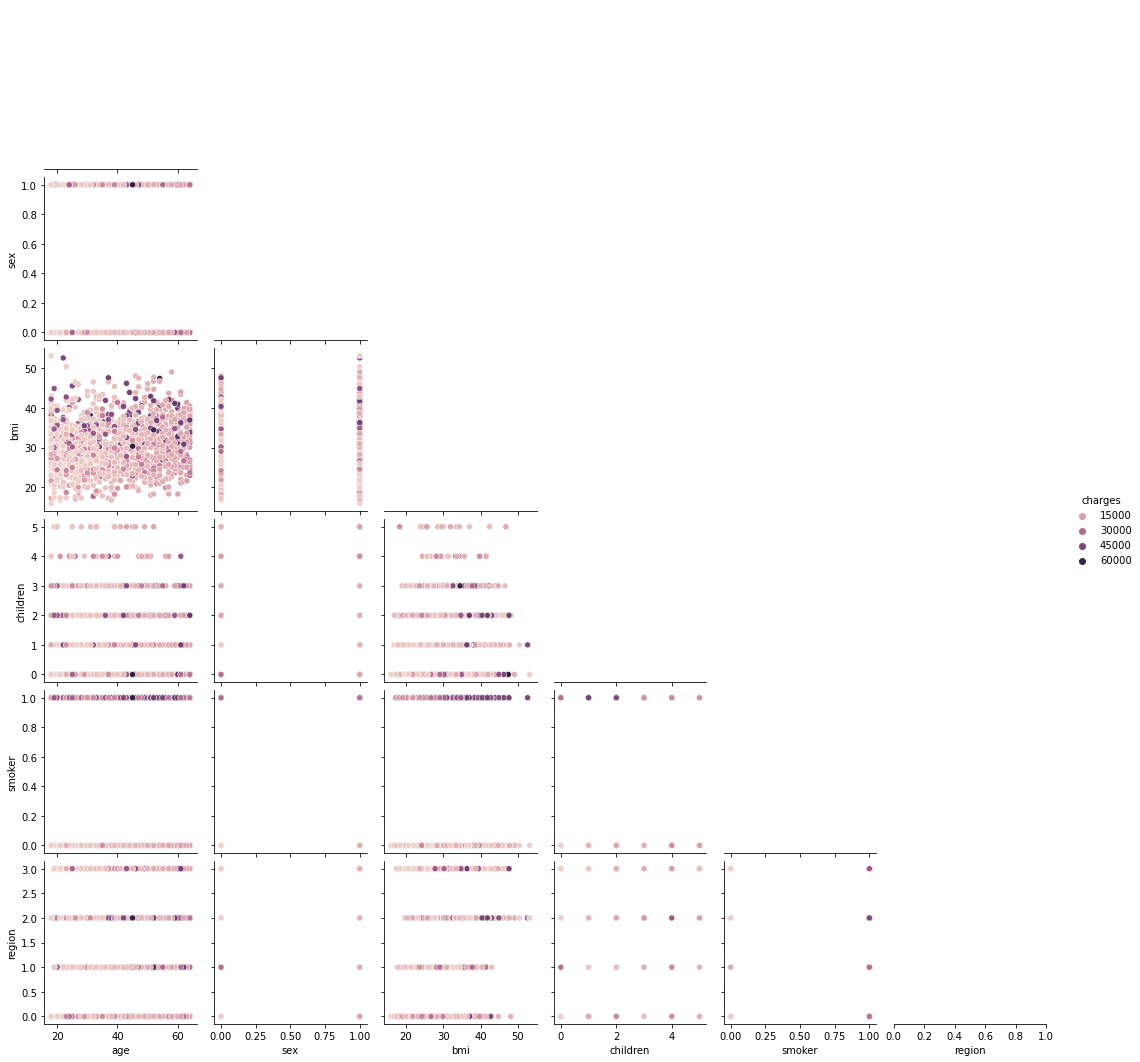

In [11]:
sns.pairplot(dataset_encoded, hue = "charges", corner=True)
plt.show()

# 3. Model training and testing - With skewed data and no attribute selection

**Explicative variables**

In [12]:
x = dataset_encoded.iloc[:,:-1].values
y = dataset_encoded.iloc[:,-1:].values
dataset_encoded.iloc[:,:-1].head()

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1


**Response variable**

In [13]:
dataset_encoded.iloc[:,-1:].head()

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520


In [42]:
def get_model(model_name, variables_dict, random_state):
    if model_name == "LinearRegression":
        variables_dict[model_name]["model"] = LinearRegression()
    elif model_name == "Lasso":
        variables_dict[model_name]["model"] = Lasso()
    elif model_name == "RandomForestRegressor":
        variables_dict[model_name]["model"] = RandomForestRegressor()
        
def plot_statistics(results):
    print("Score mean:")
    for key in results:
        print("\t{:<25}: {:.5f} %".format(key, np.mean(results[key]["score"])))

    print("MAE mean:")
    for key in results:
        print("\t{:<25}: {:.5f}".format(key, np.mean(results[key]["mae"])))

    print("MSE mean:")
    for key in results:
        print("\t{:<25}: {:.5f}".format(key, np.mean(results[key]["mse"])))

    print("R2 score mean:")
    for key in results:
        print("\t{:<25}: {:.5f}".format(key, np.mean(results[key]["r2"])))

def train(x, y, train_loop, norm = None):
    variables = {
        "LinearRegression":       { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "Lasso":                  { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "RandomForestRegressor":  { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] }
    }
    
    for i in range(train_loop):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = i)
        # data normalization during training
        if norm:
            st = StandardScaler()
            x_train = st.fit_transform(x_train)
            x_test = st.fit_transform(x_test)
        
        for key in variables:        
            get_model(key, variables, random_state = i)
            variables[key]["model"].fit(x_train, y_train)
            variables[key]["prediction"] = variables[key]["model"].predict(x_test)
            variables[key]["score"].append(variables[key]["model"].score(x_test, y_test))
            variables[key]["mae"].append(mean_absolute_error(y_test, variables[key]["prediction"]))
            variables[key]["mse"].append(mean_squared_error(y_test, variables[key]["prediction"]))
            variables[key]["r2"].append(r2_score(y_test, variables[key]["prediction"]))
    '''
    for key in variables:
        variables[key]["results"] = np.array(variables[key]["results"])
    '''
    return variables

In [43]:
def train_models(x, y):
    train_loop = 30
    return train(x, y, train_loop, True)
    
results = train_models(x, y)
plot_statistics(results)

Score mean:
	LinearRegression         : 0.74493 %
	Lasso                    : 0.74494 %
	RandomForestRegressor    : 0.83694 %
MAE mean:
	LinearRegression         : 4235.74390
	Lasso                    : 4235.61052
	RandomForestRegressor    : 2746.00905
MSE mean:
	LinearRegression         : 37161790.39671
	Lasso                    : 37161265.61187
	RandomForestRegressor    : 23779844.91869
R2 score mean:
	LinearRegression         : 0.74493
	Lasso                    : 0.74494
	RandomForestRegressor    : 0.83694


In [ ]:
!jupyter nbconvert --to html --output "notebook_file" "insurance.ipynb" --no-input